## LB 1.06
#### Just to test if model month-over-month change would make a difference

In [1]:
import os
import re
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn import model_selection
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

from itertools import product # to expand month-shop-item combo

import pickle

import gc
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm_notebook

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
def rmse_clip(y_true, y_pred):
    y_pred = y_pred.clip(0,20)
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    return(rmse)

In [3]:
def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int16`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64" or df[c].dtype == 'int32']
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int16)
    
    return df

### Read in Data

In [7]:
train = pd.read_csv(r'../data/sales_train.csv.gz')
train.shape

(2935849, 6)

In [8]:
train[:3]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.0,1.0
1,03.01.2013,0,25,2552,899.0,1.0
2,05.01.2013,0,25,2552,899.0,-1.0


#### Check what is in other data

In [9]:
items0 = pd.read_csv(r'../data2/item_category2.csv')
# shops0 = pd.read_csv(r'../data/shops.csv')
# item_cat0 = pd.read_csv(r'../data/item_categories.csv')
items0 = downcast_dtypes(items0)
items0[:3]# ok contains name of the item/cat/shop; ABBYY FineReader??

,item_id,item_category_id,item_category_id1,item_category_id2,item_category_id3,sys,product,cat1,cat2,cat3,cat1_prob,cat2_prob,cat3_prob,item_category_id2.1
0,0,40,40-16,40-23,40-10,dvd,cinema,16.0,23.0,10.0,0.520833,0.020833,0.020833,40-23
1,1,76,76-0,76-0,76-0,pc,programs,0.0,0.0,0.0,1.000000,0.000000,0.000000,76-0
2,2,40,40-23,40-22,40-1,dvd,cinema,23.0,22.0,1.0,0.041667,0.041667,0.041667,40-22


In [10]:
train[(train.shop_id==25)&(train.item_id==2552)]  
# looks like return. looks like negative rows should be removed
# Or make a "returned?" feature

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1,03.01.2013,0,25,2552,899.0,1.0
2,05.01.2013,0,25,2552,899.0,-1.0


In [11]:
(train['item_cnt_day']==0).sum()

0

In [12]:
train2 = downcast_dtypes(train[train.item_cnt_day>0])
# train2 = train[(train.item_cnt_day>0) & train.shop_id.isin(test.shop_id.unique())]

print(train2.shape)

train2['date2'] = pd.to_datetime(train2['date'],format='%d.%m.%Y')
train2.drop(labels='date',axis=1,inplace=True)

# print(train2.shop_id.nunique())
# pickle.dump(train2,open(r'../data2/train_42shops.pkl','wb'))
del train

(2928493, 6)


### Expand the month/shop/item grid

In [13]:
shops_in_tr = train2.shop_id.unique()
items_in_tr = train2.item_id.unique()
months_in_tr =train2.date_block_num.unique()
print(len(shops_in_tr),len(items_in_tr),len(months_in_tr))

grid = np.array(list(product(*[shops_in_tr,items_in_tr,months_in_tr])),dtype='int32')

grid = pd.DataFrame(grid,columns=['shop_id','item_id','date_block_num'],dtype='int32')
grid[:3]

60 21804 34


,shop_id,item_id,date_block_num
0,59,22154,0
1,59,22154,1
2,59,22154,2


In [14]:
del shops_in_tr
del items_in_tr
del months_in_tr

### Aggregate sale by month
#### Aggregate on the original data

In [15]:
train2 = pd.merge(train2, items0[['item_id','item_category_id']],how='left')
train2[:3]

,date_block_num,shop_id,item_id,item_price,item_cnt_day,date2,item_category_id
0,0,59,22154,999.000000,1.0,2013-01-02,37
1,0,25,2552,899.000000,1.0,2013-01-03,58
2,0,25,2554,1709.050049,1.0,2013-01-06,58


#### Clip daily to [0,10] and monthly to [0,20]

In [16]:
train2.loc[:,'item_cnt_day'] = train2.item_cnt_day.clip(0,10)

In [17]:
# monthly sales by shop-item
train2.sort_values(by=['date_block_num','shop_id','item_id','date2'],inplace=True)
temp = train2.groupby(['date_block_num','shop_id','item_id'],as_index=False)\
    .agg({'item_cnt_day':{'shop_item_cnt':'sum'}})

temp.columns = [col[0] if col[-1]=='' else col[-1] for col in temp.columns.values]

# clip monthly-sales to [0,20]
temp.loc[:,'shop_item_cnt'] = temp.shop_item_cnt.clip(0,20)

monthly_sales_all = pd.merge(grid, temp, how='left',on=['date_block_num','shop_id','item_id']).fillna(0)

In [19]:
monthly_sales_all.shop_item_cnt.describe()

count    4.448016e+07
mean     7.324196e-02
std      6.157979e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.000000e+01
Name: shop_item_cnt, dtype: float64

In [20]:
del grid

#### Append block 34

In [21]:
test_block = monthly_sales_all.loc[monthly_sales_all.date_block_num==33,['shop_id','item_id','date_block_num']]
test_block.loc[:,'date_block_num'] += 1
print(test_block.date_block_num.unique())
test_block[:3]

[34]


,shop_id,item_id,date_block_num
33,59,22154,34
67,59,2552,34
101,59,2554,34


In [22]:
monthly_sales_all = pd.concat([monthly_sales_all,test_block],ignore_index=True).fillna(0)

In [23]:
print(monthly_sales_all.shape)
monthly_sales_all[:3]

(45788400, 4)


,date_block_num,item_id,shop_id,shop_item_cnt
0,0,22154,59,1.0
1,1,22154,59,0.0
2,2,22154,59,0.0


In [24]:
monthly_sales_all[-5:]

,date_block_num,item_id,shop_id,shop_item_cnt
45788395,34,8428,36,0.0
45788396,34,7903,36,0.0
45788397,34,7610,36,0.0
45788398,34,7635,36,0.0
45788399,34,7640,36,0.0


In [25]:
del test_block

In [26]:
gc.collect()

20

#### Visualize sales trend (and diff trend)

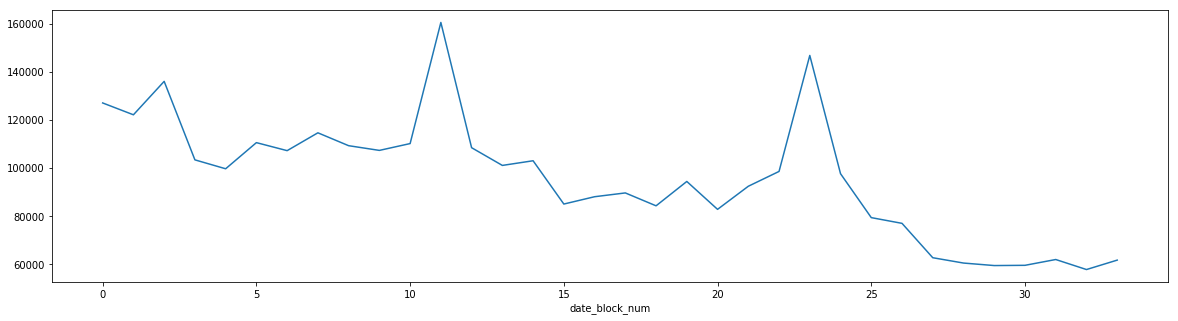

In [23]:
# Clear seasonality - spike in Dec; March
# Also a clear downward sloping trend
plt.figure(figsize=(20,5))
monthly_sales_all[monthly_sales_all.date_block_num<34].groupby(['date_block_num'])['shop_item_cnt'].sum().plot() 

In [27]:
monthly_sales_all.sort_values(by=['shop_id','item_id','date_block_num'],inplace=True)
monthly_sales_all['shop_item_cnt_lag1']=monthly_sales_all.groupby(['shop_id','item_id'])['shop_item_cnt'].shift(1)

monthly_sales_all['diff'] = monthly_sales_all['shop_item_cnt'] - monthly_sales_all['shop_item_cnt_lag1']

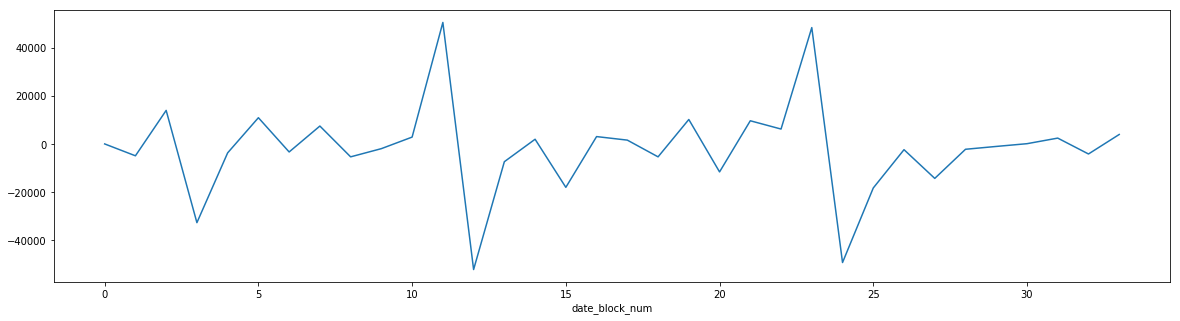

In [28]:
# Frist order diff seems stationary
plt.figure(figsize=(20,5))
monthly_sales_all[monthly_sales_all.date_block_num<34].groupby(['date_block_num'])['diff'].sum().plot() 

In [29]:
monthly_sales_all[monthly_sales_all.date_block_num==34]['diff'].max() # QC should <=0

0.0

In [30]:
print(monthly_sales_all[monthly_sales_all['diff'].isnull()].date_block_num.unique())  # QC
monthly_sales_all = monthly_sales_all[monthly_sales_all['diff'].notnull()] # Remove date_block_num 0 where no diff is available

[0]


#### Aggregated Diff by Shop, Cat, Item

In [31]:
# monthly sales by shop
temp = monthly_sales_all.groupby(['date_block_num','shop_id'],as_index=False).agg({'diff':{'shop_cnt':'sum'}})
temp.columns = [col[0] if col[-1]=='' else col[-1] for col in temp.columns.values]

monthly_sales_all=pd.merge(monthly_sales_all,temp,how='left',on=['date_block_num','shop_id']).fillna(0)

# monthly sales by item
temp = monthly_sales_all.groupby(['date_block_num','item_id'],as_index=False).agg({'diff':{'item_cnt':'sum'}})
temp.columns = [col[0] if col[-1]=='' else col[-1] for col in temp.columns.values]

monthly_sales_all=pd.merge(monthly_sales_all,temp,how='left',on=['date_block_num','item_id']).fillna(0)

monthly_sales_all[:3]

,date_block_num,item_id,shop_id,shop_item_cnt,shop_item_cnt_lag1,diff,shop_cnt,item_cnt
0,1,0,0,0.0,0.0,0.0,409.0,0.0
1,2,0,0,0.0,0.0,0.0,-5820.0,0.0
2,3,0,0,0.0,0.0,0.0,0.0,0.0


In [32]:
# monthly sales by cat
# first, get item_category_id1 of each item on the LHS
monthly_sales_all = pd.merge(monthly_sales_all,items0[['item_id','item_category_id','sys',
                                                       'item_category_id1','item_category_id2','item_category_id3',
                                                       'cat1_prob','cat2_prob','cat3_prob']],
                             how='left',on='item_id')

# by cat
temp = monthly_sales_all.groupby(['date_block_num','item_category_id'],as_index=False).agg({'diff':{'cat_cnt':'sum'}})
temp.columns = [col[0] if col[-1]=='' else col[-1] for col in temp.columns.values]
monthly_sales_all=pd.merge(monthly_sales_all,temp,how='left',on=['date_block_num','item_category_id']).fillna(0)

# by sys
temp = monthly_sales_all.groupby(['date_block_num','sys'],as_index=False).agg({'diff':{'sys_cnt':'sum'}})
temp.columns = [col[0] if col[-1]=='' else col[-1] for col in temp.columns.values]
monthly_sales_all=pd.merge(monthly_sales_all,temp,how='left',on=['date_block_num','sys']).fillna(0)

In [34]:
monthly_sales_all[:3]

,date_block_num,item_id,shop_id,shop_item_cnt,shop_item_cnt_lag1,diff,shop_cnt,item_cnt,item_category_id,sys,item_category_id1,item_category_id2,item_category_id3,cat1_prob,cat2_prob,cat3_prob,cat_cnt,sys_cnt
0,1,0,0,0.0,0.0,0.0,409.0,0.0,40,dvd,40-16,40-23,40-10,0.520833,0.020833,0.020833,-2365.0,-2391.0
1,2,0,0,0.0,0.0,0.0,-5820.0,0.0,40,dvd,40-16,40-23,40-10,0.520833,0.020833,0.020833,4249.0,4292.0
2,3,0,0,0.0,0.0,0.0,0.0,0.0,40,dvd,40-16,40-23,40-10,0.520833,0.020833,0.020833,-7772.0,-8139.0


In [35]:
# cat mix
temp = monthly_sales_all.groupby(['date_block_num','item_category_id1'],as_index=False).agg({'diff':{'cat1_cnt':'sum'}})
temp.columns = [col[0] if col[-1]=='' else col[-1] for col in temp.columns.values]
monthly_sales_all=pd.merge(monthly_sales_all,temp,how='left',on=['date_block_num','item_category_id1']).fillna(0)

temp = monthly_sales_all.groupby(['date_block_num','item_category_id2'],as_index=False).agg({'diff':{'cat2_cnt':'sum'}})
temp.columns = [col[0] if col[-1]=='' else col[-1] for col in temp.columns.values]
monthly_sales_all=pd.merge(monthly_sales_all,temp,how='left',on=['date_block_num','item_category_id2']).fillna(0)

temp = monthly_sales_all.groupby(['date_block_num','item_category_id3'],as_index=False).agg({'diff':{'cat3_cnt':'sum'}})
temp.columns = [col[0] if col[-1]=='' else col[-1] for col in temp.columns.values]
monthly_sales_all=pd.merge(monthly_sales_all,temp,how='left',on=['date_block_num','item_category_id3']).fillna(0)

# # downcast types to save memory
monthly_sales_all=downcast_dtypes(monthly_sales_all)
print(monthly_sales_all.shape)
monthly_sales_all[:3]

(44480160, 21)


,date_block_num,item_id,shop_id,shop_item_cnt,shop_item_cnt_lag1,diff,shop_cnt,item_cnt,item_category_id,sys,...,item_category_id2,item_category_id3,cat1_prob,cat2_prob,cat3_prob,cat_cnt,sys_cnt,cat1_cnt,cat2_cnt,cat3_cnt
0,1,0,0,0.0,0.0,0.0,409.0,0.0,40,dvd,...,40-23,40-10,0.520833,0.020833,0.020833,-2365.0,-2391.0,-379.0,400.0,-1795.0
1,2,0,0,0.0,0.0,0.0,-5820.0,0.0,40,dvd,...,40-23,40-10,0.520833,0.020833,0.020833,4249.0,4292.0,-164.0,859.0,2376.0
2,3,0,0,0.0,0.0,0.0,0.0,0.0,40,dvd,...,40-23,40-10,0.520833,0.020833,0.020833,-7772.0,-8139.0,863.0,-1772.0,-2322.0


In [36]:
monthly_sales_all['cat_mix_cnt'] = monthly_sales_all.cat1_cnt * monthly_sales_all.cat1_prob + \
                               monthly_sales_all.cat2_cnt * monthly_sales_all.cat2_prob + \
                               monthly_sales_all.cat3_cnt * monthly_sales_all.cat3_prob

In [37]:
to_drop = [col for col in monthly_sales_all.columns if re.search(re.compile('item_category_id|_prob|cat[0-9]'), col) is not None]
monthly_sales_all.drop(labels=to_drop,axis=1,inplace=True)

In [38]:
del train2
del temp

In [39]:
monthly_sales_all[['date_block_num','shop_id']] = monthly_sales_all[['date_block_num','shop_id']].astype(np.int8)

In [40]:
monthly_sales_all.dtypes

date_block_num           int8
item_id                 int16
shop_id                  int8
shop_item_cnt         float32
shop_item_cnt_lag1    float32
diff                  float32
shop_cnt              float32
item_cnt              float32
sys                    object
cat_cnt               float32
sys_cnt               float32
cat_mix_cnt           float32
dtype: object

### Start building features

#### Set up time-based features

<strong>Since we have lag features, we are just going to build the features on entire monthly_sales data w/o spliting monthly_sales and X_val. 
    
However, make sure we do feature selection only on the monthly_sales portion (where date_block_num < hold_out_month) </strong>

In [41]:
temp = monthly_sales_all[['shop_id','item_id','date_block_num','shop_item_cnt','shop_item_cnt_lag1']]

In [42]:
%%time
temp.to_hdf(r'../data2/temp.h5','monthly_sales_all')

Wall time: 11.4 s


In [43]:
del temp

In [46]:
# monthly_sales_all.drop(labels=['shop_item_cnt','shop_item_cnt_lag1'],axis=1,inplace=True)
monthly_sales_all.drop(labels=['sys'],axis=1,inplace=True)

In [54]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaler

MinMaxScaler(copy=True, feature_range=(-1, 1))

In [55]:
monthly_sales_all.loc[:,cols_to_rename] = scaler.fit_transform(monthly_sales_all[cols_to_rename])
monthly_sales_all[cols_to_rename].describe()

,cat_cnt,cat_mix_cnt,diff,item_cnt,shop_cnt,sys_cnt
count,4.448016e+07,4.448016e+07,4.448016e+07,4.448016e+07,4.448016e+07,4.448016e+07
mean,7.863188e-02,7.974185e-03,-1.427873e-04,-6.324264e-02,-4.704844e-02,4.675910e-02
std,2.490238e-01,1.071540e-01,2.808831e-02,1.942277e-02,1.088910e-01,2.143709e-01
min,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00
25%,2.681605e-02,-8.655725e-03,0.000000e+00,-6.305310e-02,-6.305859e-02,-1.513774e-02
50%,1.216480e-01,1.395123e-02,0.000000e+00,-6.305310e-02,-3.674280e-02,5.916020e-02
75%,1.528731e-01,2.543641e-02,0.000000e+00,-6.305310e-02,-2.068851e-02,1.212089e-01
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [56]:
gc.collect()

93

In [64]:
monthly_sales_all = downcast_dtypes(monthly_sales_all)

In [65]:
monthly_sales_all[cols_to_rename].dtypes

cat_cnt        float32
cat_mix_cnt    float32
diff           float32
item_cnt       float32
shop_cnt       float32
sys_cnt        float32
dtype: object

In [66]:
monthly_sales_all.to_hdf(r'../data2/monthly_sales_diff_no_lag.h5','monthly_sales_all')

In [4]:
monthly_sales_all = pd.read_hdf(r'../data2/monthly_sales_diff_no_lag.h5','monthly_sales_all')

In [5]:
index_cols = ['shop_id','item_id','date_block_num']
cols_to_rename = list(monthly_sales_all.columns.difference(index_cols)) # all columns except these four
shift_range = [1,2,3,4,5,12]
cols_to_rename

['cat_cnt', 'cat_mix_cnt', 'diff', 'item_cnt', 'shop_cnt', 'sys_cnt']

In [6]:
for month_shift in tqdm_notebook(shift_range):
    
    """Take the entire data set, add 1 to date_block_num, and rename the columns that we want to create a lag for"""
    
    train_shift = monthly_sales_all[index_cols + cols_to_rename].copy()
    
    train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
    
    foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
    train_shift = train_shift.rename(columns=foo)

    monthly_sales_all = pd.merge(monthly_sales_all, train_shift, on=index_cols, how='left').fillna(0)

del train_shift

In [7]:
gc.collect()

214

In [8]:
monthly_sales_all['month'] = (np.mod(monthly_sales_all.date_block_num,12)+1).astype('int8')

In [9]:
temp = pd.read_hdf(r'../data2/temp.h5','monthly_sales_all')
print(temp.shape)
temp[:3]

(44480160, 5)


,shop_id,item_id,date_block_num,shop_item_cnt,shop_item_cnt_lag1
0,0,0,1,0.0,0.0
1,0,0,2,0.0,0.0
2,0,0,3,0.0,0.0


In [11]:
temp[['shop_item_cnt','shop_item_cnt_lag1']].describe()

,shop_item_cnt,shop_item_cnt_lag1
count,4.448016e+07,4.448016e+07
mean,7.038622e-02,7.324196e-02
std,6.040751e-01,6.155989e-01
min,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00
75%,0.000000e+00,0.000000e+00
max,2.000000e+01,2.000000e+01


In [12]:
monthly_sales_all = pd.merge(monthly_sales_all,temp, on=['date_block_num','shop_id','item_id'],how='left')
print(monthly_sales_all.shape)
monthly_sales_all[:3]

(44480160, 48)


,date_block_num,item_id,shop_id,diff,shop_cnt,item_cnt,cat_cnt,sys_cnt,cat_mix_cnt,cat_cnt_lag_1,...,sys_cnt_lag_5,cat_cnt_lag_12,cat_mix_cnt_lag_12,diff_lag_12,item_cnt_lag_12,shop_cnt_lag_12,sys_cnt_lag_12,month,shop_item_cnt,shop_item_cnt_lag1
0,1,0,0,0.0,0.030950,-0.063053,-0.218359,-0.049425,-0.059837,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0.0,0.0
1,2,0,0,0.0,-1.000000,-0.063053,0.737767,0.308050,0.009469,-0.218359,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,0.0,0.0
2,3,0,0,0.0,-0.036743,-0.063053,-1.000000,-0.356887,0.136554,0.737767,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,0.0,0.0


In [17]:
monthly_sales_all.drop(labels=['cat_cnt','cat_mix_cnt','item_cnt','shop_cnt','sys_cnt'],axis=1,inplace=True)

In [18]:
monthly_sales_all[:3]

,date_block_num,item_id,shop_id,diff,cat_cnt_lag_1,cat_mix_cnt_lag_1,diff_lag_1,item_cnt_lag_1,shop_cnt_lag_1,sys_cnt_lag_1,...,sys_cnt_lag_5,cat_cnt_lag_12,cat_mix_cnt_lag_12,diff_lag_12,item_cnt_lag_12,shop_cnt_lag_12,sys_cnt_lag_12,month,shop_item_cnt,shop_item_cnt_lag1
0,1,0,0,0.0,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0.0,0.0
1,2,0,0,0.0,-0.218359,-0.059837,0.0,-0.063053,0.03095,-0.049425,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,0.0,0.0
2,3,0,0,0.0,0.737767,0.009469,0.0,-0.063053,-1.00000,0.308050,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,0.0,0.0


In [19]:
%%time
monthly_sales_all.to_hdf(r'../data2/monthly_diff_all_shop_item_w_lag.h5','monthly_sales_all')

Wall time: 1min 3s


In [4]:
%%time
monthly_sales_all = pd.read_hdf(r'../data2/monthly_diff_all_shop_item_w_lag.h5','monthly_sales_all')

Wall time: 1min 4s


In [5]:
monthly_sales_all = monthly_sales_all[monthly_sales_all.date_block_num>=12]

In [8]:
monthly_sales_all.dtypes

date_block_num           int8
item_id                 int16
shop_id                  int8
diff                  float32
cat_cnt_lag_1         float32
cat_mix_cnt_lag_1     float32
diff_lag_1            float32
item_cnt_lag_1        float32
shop_cnt_lag_1        float32
sys_cnt_lag_1         float32
cat_cnt_lag_2         float32
cat_mix_cnt_lag_2     float32
diff_lag_2            float32
item_cnt_lag_2        float32
shop_cnt_lag_2        float32
sys_cnt_lag_2         float32
cat_cnt_lag_3         float32
cat_mix_cnt_lag_3     float32
diff_lag_3            float32
item_cnt_lag_3        float32
shop_cnt_lag_3        float32
sys_cnt_lag_3         float32
cat_cnt_lag_4         float32
cat_mix_cnt_lag_4     float32
diff_lag_4            float32
item_cnt_lag_4        float32
shop_cnt_lag_4        float32
sys_cnt_lag_4         float32
cat_cnt_lag_5         float32
cat_mix_cnt_lag_5     float32
diff_lag_5            float32
item_cnt_lag_5        float32
shop_cnt_lag_5        float32
sys_cnt_la

### Tree-based features

In [9]:
# Need to scale diff back to [-20,20], for shop_item_cnt and shop_item_cnt_lag1 are unscaled
temp = MinMaxScaler(feature_range=(-20,20)).fit_transform(monthly_sales_all[['diff']]).ravel()

monthly_sales_all.loc[:,'diff'] = temp
monthly_sales_all['diff'].describe()

count    3.008952e+07
mean    -5.335479e-03
std      5.238676e-01
min     -2.000000e+01
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.000000e+01
Name: diff, dtype: float64

In [10]:
monthly_sales_all['diff_ma1'] = (1/3) * (monthly_sales_all['diff_lag_1'] + monthly_sales_all['diff_lag_2'] + monthly_sales_all['diff_lag_3'])
monthly_sales_all['diff_ma2'] = (1/3) * (monthly_sales_all['diff_lag_2'] + monthly_sales_all['diff_lag_3'] + monthly_sales_all['diff_lag_4'])
monthly_sales_all['diff_ma3'] = (1/3) * (monthly_sales_all['diff_lag_3'] + monthly_sales_all['diff_lag_4'] + monthly_sales_all['diff_lag_5'])

In [11]:
monthly_sales_all['item_ma1'] = (1/3) * (monthly_sales_all['item_cnt_lag_1'] + monthly_sales_all['item_cnt_lag_2'] + monthly_sales_all['item_cnt_lag_3'])
monthly_sales_all['item_ma2'] = (1/3) * (monthly_sales_all['item_cnt_lag_2'] + monthly_sales_all['item_cnt_lag_3'] + monthly_sales_all['item_cnt_lag_4'])
monthly_sales_all['item_ma3'] = (1/3) * (monthly_sales_all['item_cnt_lag_3'] + monthly_sales_all['item_cnt_lag_4'] + monthly_sales_all['item_cnt_lag_5'])

monthly_sales_all['shop_ma1'] = (1/3) * (monthly_sales_all['shop_cnt_lag_1'] + monthly_sales_all['shop_cnt_lag_2'] + monthly_sales_all['shop_cnt_lag_3'])
monthly_sales_all['shop_ma2'] = (1/3) * (monthly_sales_all['shop_cnt_lag_2'] + monthly_sales_all['shop_cnt_lag_3'] + monthly_sales_all['shop_cnt_lag_4'])
monthly_sales_all['shop_ma3'] = (1/3) * (monthly_sales_all['shop_cnt_lag_3'] + monthly_sales_all['shop_cnt_lag_4'] + monthly_sales_all['shop_cnt_lag_5'])

monthly_sales_all['cat_ma1'] = (1/3) * (monthly_sales_all['cat_cnt_lag_1'] + monthly_sales_all['cat_cnt_lag_2'] + monthly_sales_all['cat_cnt_lag_3'])
monthly_sales_all['cat_ma2'] = (1/3) * (monthly_sales_all['cat_cnt_lag_2'] + monthly_sales_all['cat_cnt_lag_3'] + monthly_sales_all['cat_cnt_lag_4'])
monthly_sales_all['cat_ma3'] = (1/3) * (monthly_sales_all['cat_cnt_lag_3'] + monthly_sales_all['cat_cnt_lag_4'] + monthly_sales_all['cat_cnt_lag_5'])

In [12]:
monthly_sales_all['cat_mix_ma1'] = (1/3) * (monthly_sales_all['cat_mix_cnt_lag_1'] + monthly_sales_all['cat_mix_cnt_lag_2'] + monthly_sales_all['cat_mix_cnt_lag_3'])
monthly_sales_all['cat_mix_ma2'] = (1/3) * (monthly_sales_all['cat_mix_cnt_lag_2'] + monthly_sales_all['cat_mix_cnt_lag_3'] + monthly_sales_all['cat_mix_cnt_lag_4'])
monthly_sales_all['cat_mix_ma3'] = (1/3) * (monthly_sales_all['cat_mix_cnt_lag_3'] + monthly_sales_all['cat_mix_cnt_lag_4'] + monthly_sales_all['cat_mix_cnt_lag_5'])

monthly_sales_all['sys_ma1'] = (1/3) * (monthly_sales_all['sys_cnt_lag_1'] + monthly_sales_all['sys_cnt_lag_2'] + monthly_sales_all['sys_cnt_lag_3'])
monthly_sales_all['sys_ma2'] = (1/3) * (monthly_sales_all['sys_cnt_lag_2'] + monthly_sales_all['sys_cnt_lag_3'] + monthly_sales_all['sys_cnt_lag_4'])
monthly_sales_all['sys_ma3'] = (1/3) * (monthly_sales_all['sys_cnt_lag_3'] + monthly_sales_all['sys_cnt_lag_4'] + monthly_sales_all['sys_cnt_lag_5'])

In [13]:
monthly_sales_all=downcast_dtypes(monthly_sales_all)

In [14]:
monthly_sales_all[['diff','shop_item_cnt','shop_item_cnt_lag1']].describe()

,diff,shop_item_cnt,shop_item_cnt_lag1
count,3.008952e+07,3.008952e+07,3.008952e+07
mean,-5.335479e-03,6.149354e-02,6.682902e-02
std,5.238945e-01,5.584093e-01,5.868613e-01
min,-2.000000e+01,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00
75%,0.000000e+00,0.000000e+00,0.000000e+00
max,2.000000e+01,2.000000e+01,2.000000e+01


In [15]:
monthly_sales_all.to_hdf(r'../data2/tree_feats_diff_ex_1st_12month.h5','monthly_sales_all')

### Linear features

- <strong>One-hot encode month</strong>

In [6]:
enc = OneHotEncoder()

In [7]:
m_onehot = enc.fit_transform(pd.DataFrame(list(range(1,13)))).toarray()
m_onehot.shape
# 12 levels -> 12 features, need to drop 1 to avoid multicolinearity (since we are first going to fit a linear model)

# reshape(-1,1) -1 means unknown dimension which we just let numpy to figure out
# since OneHotEncoder() takes 2-D array, we need to make our 1D series into a 2-D matrix format
# we know there is one column, and let numpy to figure out how many rows there should be
# <=> reshape.(rows_in_your_data,1)

(12, 12)

In [8]:
m_onehot_df = pd.DataFrame(np.hstack((np.array(range(1,13)).reshape(12,1),m_onehot[:,1:])), columns=['month']+['m'+str(i) for i in range(2,13)], dtype='int8')
m_onehot_df

,month,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12
0,1,0,0,0,0,0,0,0,0,0,0,0
1,2,1,0,0,0,0,0,0,0,0,0,0
2,3,0,1,0,0,0,0,0,0,0,0,0
3,4,0,0,1,0,0,0,0,0,0,0,0
4,5,0,0,0,1,0,0,0,0,0,0,0
5,6,0,0,0,0,1,0,0,0,0,0,0
6,7,0,0,0,0,0,1,0,0,0,0,0
7,8,0,0,0,0,0,0,1,0,0,0,0
8,9,0,0,0,0,0,0,0,1,0,0,0
9,10,0,0,0,0,0,0,0,0,1,0,0


In [9]:
monthly_sales_all = pd.merge(monthly_sales_all,m_onehot_df,how='left',on='month').drop(labels=['month'],axis=1)
monthly_sales_all[:3]

,date_block_num,item_id,shop_id,diff,shop_cnt,item_cnt,cat_cnt,sys_cnt,cat_mix_cnt,cat_cnt_lag_1,...,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12
0,12,0,0,0.0,-0.036743,-0.063053,-0.657246,-0.234287,-0.017436,0.616480,...,0,0,0,0,0,0,0,0,0,0
1,13,0,0,0.0,-0.036743,-0.063053,-0.380846,-0.122279,-0.062781,-0.657246,...,0,0,0,0,0,0,0,0,0,0
2,14,0,0,0.0,-0.036743,-0.063053,0.423780,0.187376,0.003858,-0.380846,...,1,0,0,0,0,0,0,0,0,0


In [10]:
monthly_sales_all = downcast_dtypes(monthly_sales_all)
monthly_sales_all.dtypes

date_block_num           int8
item_id                 int16
shop_id                  int8
diff                  float32
shop_cnt              float32
item_cnt              float32
cat_cnt               float32
sys_cnt               float32
cat_mix_cnt           float32
cat_cnt_lag_1         float32
cat_mix_cnt_lag_1     float32
diff_lag_1            float32
item_cnt_lag_1        float32
shop_cnt_lag_1        float32
sys_cnt_lag_1         float32
cat_cnt_lag_2         float32
cat_mix_cnt_lag_2     float32
diff_lag_2            float32
item_cnt_lag_2        float32
shop_cnt_lag_2        float32
sys_cnt_lag_2         float32
cat_cnt_lag_3         float32
cat_mix_cnt_lag_3     float32
diff_lag_3            float32
item_cnt_lag_3        float32
shop_cnt_lag_3        float32
sys_cnt_lag_3         float32
cat_cnt_lag_4         float32
cat_mix_cnt_lag_4     float32
diff_lag_4            float32
item_cnt_lag_4        float32
shop_cnt_lag_4        float32
sys_cnt_lag_4         float32
cat_cnt_la

In [18]:
monthly_sales_all['diff'].describe()

count    2.878128e+07
mean    -1.719106e-04
std      2.627628e-02
min     -1.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+00
Name: diff, dtype: float64

In [19]:
# Need to scale diff back to [-20,20], for shop_item_cnt and shop_item_cnt_lag1 are unscaled
temp = MinMaxScaler(feature_range=(-20,20)).fit_transform(monthly_sales_all[['diff']]).ravel()

monthly_sales_all.loc[:,'diff'] = temp
monthly_sales_all['diff'].describe()

count    2.878128e+07
mean    -3.438033e-03
std      5.251659e-01
min     -2.000000e+01
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.000000e+01
Name: diff, dtype: float64

In [20]:
%%time
monthly_sales_all.to_hdf(r'../data2/lm_feat_diff_ex_1st_12_month.h5','monthly_sales_all')

Wall time: 1min 1s


#### Predict w lag v RF w lag

In [51]:
hold_out_month = 33
val_month = 32

In [50]:
feats = ['diff_lag_1']

In [51]:
monthly_sales_all[:3]

,date_block_num,item_id,shop_id,shop_item_cnt,diff,shop_cnt,item_cnt,item_category_id,cat_cnt,cat_cnt_lag_1,...,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12
0,12,0,0,0.0,0.0,0.0,0.0,40,-6536.0,3162.0,...,0,0,0,0,0,0,0,0,0,0
1,13,0,0,0.0,0.0,0.0,0.0,40,-3597.0,-6536.0,...,0,0,0,0,0,0,0,0,0,0
2,14,0,0,0.0,0.0,0.0,0.0,40,2796.0,-3597.0,...,1,0,0,0,0,0,0,0,0,0


In [81]:
hold_out_df = monthly_sales_all.loc[monthly_sales_all.date_block_num == hold_out_month,
                            ['shop_id','item_id','shop_item_cnt','shop_item_cnt_lag_1','diff']+feats]
val = monthly_sales_all.loc[monthly_sales_all.date_block_num == val_month,
                            ['shop_id','item_id','shop_item_cnt','shop_item_cnt_lag_1','diff']+feats]
val[:3]

,shop_id,item_id,shop_item_cnt,shop_item_cnt_lag_1,diff,diff_lag_1,item_cnt_lag_1,shop_cnt_lag_1,cat_cnt_lag_1,diff_lag_2,...,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12
20,0,0,0.0,NaN,0.0,0.0,0.0,0.0,-766.0,0.0,...,0,0,0,0,0,0,1,0,0,0
42,0,1,0.0,NaN,0.0,0.0,0.0,0.0,-16.0,0.0,...,0,0,0,0,0,0,1,0,0,0
64,0,2,0.0,NaN,0.0,0.0,0.0,0.0,-766.0,0.0,...,0,0,0,0,0,0,1,0,0,0


#### Benchmark - on val and hold-out

In [54]:
print('Hold out BC (month 33):')
print(rmse_clip(y_true = hold_out_df.loc[hold_out_df.shop_item_cnt>0,'shop_item_cnt'],y_pred = hold_out_df.loc[hold_out_df.shop_item_cnt>0,'shop_item_cnt_lag_1']))

Hold out BC (month 33):
14.068433535527497


In [39]:
print('Val BC (month 32)')
print(rmse_clip(y_true = val.loc[val.shop_item_cnt>0,'shop_item_cnt'],y_pred = val.loc[val.shop_item_cnt>0,'diff']))

Val BC (month 32)
18.07412546239703


#### Model

In [61]:
monthly_sales_all.columns

Index(['date_block_num', 'item_id', 'shop_id', 'diff', 'shop_cnt', 'item_cnt',
       'item_category_id', 'cat_cnt', 'cat_cnt_lag_1', 'diff_lag_1',
       'item_cnt_lag_1', 'shop_cnt_lag_1', 'cat_cnt_lag_2', 'diff_lag_2',
       'item_cnt_lag_2', 'shop_cnt_lag_2', 'cat_cnt_lag_3', 'diff_lag_3',
       'item_cnt_lag_3', 'shop_cnt_lag_3', 'cat_cnt_lag_4', 'diff_lag_4',
       'item_cnt_lag_4', 'shop_cnt_lag_4', 'cat_cnt_lag_5', 'diff_lag_5',
       'item_cnt_lag_5', 'shop_cnt_lag_5', 'cat_cnt_lag_12', 'diff_lag_12',
       'item_cnt_lag_12', 'shop_cnt_lag_12', 'shop_item_cnt',
       'shop_item_cnt_lag1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9',
       'm10', 'm11', 'm12'],
      dtype='object')

In [52]:
feats = ['diff_lag_1',  'item_cnt_lag_1',  'shop_cnt_lag_1', 'cat_cnt_lag_1',
         'diff_lag_2',  'item_cnt_lag_2',  'shop_cnt_lag_2', 'cat_cnt_lag_2',
         'diff_lag_3',  'item_cnt_lag_3',  'shop_cnt_lag_3', 'cat_cnt_lag_3',
         'diff_lag_4',  'item_cnt_lag_4',  'shop_cnt_lag_4', 'cat_cnt_lag_4',
         'diff_lag_5',  'item_cnt_lag_5',  'shop_cnt_lag_5', 'cat_cnt_lag_5',
         'diff_lag_12', 'item_cnt_lag_12', 'shop_cnt_lag_12','cat_cnt_lag_12',
#          'month'
         'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12'
        ]

In [53]:
hold_out_df = monthly_sales_all.loc[monthly_sales_all.date_block_num == hold_out_month,
                            ['shop_id','item_id','shop_item_cnt','diff','shop_item_cnt_lag1']+feats]
val = monthly_sales_all.loc[monthly_sales_all.date_block_num == val_month,
                            ['shop_id','item_id','shop_item_cnt','diff','shop_item_cnt_lag1']+feats]
val[:3]

,shop_id,item_id,shop_item_cnt,diff,shop_item_cnt_lag1,diff_lag_1,item_cnt_lag_1,shop_cnt_lag_1,cat_cnt_lag_1,diff_lag_2,...,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12
20,0,0,0.0,0.0,0.0,0.0,0.0,0.0,6.708333,0.0,...,0,0,0,0,0,0,1,0,0,0
42,0,1,0.0,0.0,0.0,0.0,0.0,0.0,-16.000000,0.0,...,0,0,0,0,0,0,1,0,0,0
64,0,2,0.0,0.0,0.0,0.0,0.0,0.0,-44.750004,0.0,...,0,0,0,0,0,0,1,0,0,0


In [54]:
gc.collect()

303

In [55]:
X_train = monthly_sales_all.loc[monthly_sales_all.date_block_num<val_month,feats]
y_train = monthly_sales_all.loc[monthly_sales_all.date_block_num<val_month,'diff']

In [56]:
del monthly_sales_all
gc.collect()

7

In [57]:
%%time
corr = X_train.corr()

Wall time: 1min 39s


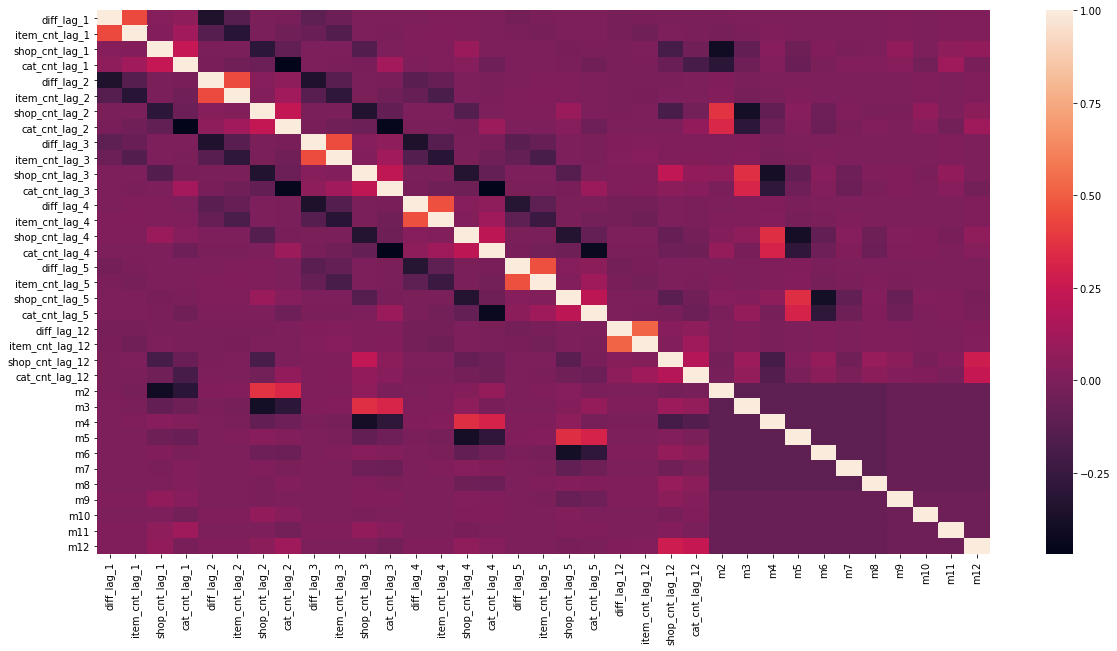

In [58]:
plt.figure(figsize=(20,10))
sns.heatmap(corr)

In [59]:
lm = LinearRegression()

In [61]:
lm.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [62]:
pred_lm = lm.predict(val[feats])

In [63]:
rmse_clip(y_true = val.loc[val.shop_item_cnt>0,'shop_item_cnt'],
          y_pred = pred_lm[val.shop_item_cnt>0]+ val.loc[val.shop_item_cnt>0,'shop_item_cnt_lag1'])

18.140688926459283

In [64]:
gc.collect()

208

##### LGB

In [79]:
%%time
monthly_sales_all = pd.read_hdf(r'../data2/monthly_diff_all_shop_item_w_lag.h5','monthly_sales_all')

Wall time: 4.19 s


In [74]:
monthly_sales_all = monthly_sales_all[(monthly_sales_all.date_block_num>=12) & (monthly_sales_all.date_block_num<34)]

In [75]:
feats = ['diff_lag_1',  'item_cnt_lag_1',  'shop_cnt_lag_1', 'cat_cnt_lag_1',
         'diff_lag_2',  'item_cnt_lag_2',  'shop_cnt_lag_2', 'cat_cnt_lag_2',
         'diff_lag_3',  'item_cnt_lag_3',  'shop_cnt_lag_3', 'cat_cnt_lag_3',
         'diff_lag_4',  'item_cnt_lag_4',  'shop_cnt_lag_4', 'cat_cnt_lag_4',
         'diff_lag_5',  'item_cnt_lag_5',  'shop_cnt_lag_5', 'cat_cnt_lag_5',
         'diff_lag_12', 'item_cnt_lag_12', 'shop_cnt_lag_12','cat_cnt_lag_12',
         'month'
#          'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12'
        ]

In [80]:
hold_out_df = monthly_sales_all.loc[monthly_sales_all.date_block_num == hold_out_month,
                            ['shop_id','item_id','shop_item_cnt','diff','shop_item_cnt_lag1']+feats]
val = monthly_sales_all.loc[monthly_sales_all.date_block_num == val_month,
                            ['shop_id','item_id','shop_item_cnt','diff','shop_item_cnt_lag1']+feats]
val[:3]

,shop_id,item_id,shop_item_cnt,diff,shop_item_cnt_lag1,diff_lag_1,item_cnt_lag_1,shop_cnt_lag_1,cat_cnt_lag_1,diff_lag_2,...,cat_cnt_lag_4,diff_lag_5,item_cnt_lag_5,shop_cnt_lag_5,cat_cnt_lag_5,diff_lag_12,item_cnt_lag_12,shop_cnt_lag_12,cat_cnt_lag_12,month
31,0,0,0.0,0.0,0.0,0.0,0.0,0.0,6.708333,0.0,...,-30.770832,0.0,0.0,0.0,-150.583328,0.0,1.0,0.0,-70.187492,9
65,0,1,0.0,0.0,0.0,0.0,0.0,0.0,-16.000000,0.0,...,-54.000000,0.0,0.0,0.0,-5.000000,0.0,0.0,0.0,13.000000,9
99,0,2,0.0,0.0,0.0,0.0,0.0,0.0,-44.750004,0.0,...,0.250000,0.0,0.0,0.0,-61.458336,0.0,-1.0,0.0,-81.750000,9


In [76]:
X_train = monthly_sales_all.loc[monthly_sales_all.date_block_num<val_month,feats]
y_train = monthly_sales_all.loc[monthly_sales_all.date_block_num<val_month,'diff']

In [77]:
del monthly_sales_all
gc.collect()

82

In [81]:
%%time
lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':7, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':0 
              }

model = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train), 100)

Wall time: 1min 53s


In [82]:
pred_lgb = model.predict(val[feats])
print("Val (32):",
      rmse_clip(y_true = val.loc[val.shop_item_cnt>0,'shop_item_cnt'],
                y_pred = pred_lgb[val.shop_item_cnt>0] + val.loc[val.shop_item_cnt>0,'shop_item_cnt_lag1']))

Val (32): 18.10268846314692


In [83]:
print("Val (32):",
      rmse_clip(y_true = val.loc[(val.shop_item_cnt>0) & (val.shop_item_cnt<20),'shop_item_cnt'],
                y_pred = pred_lgb[(val.shop_item_cnt>0) & (val.shop_item_cnt<20)] + val.loc[(val.shop_item_cnt>0) & (val.shop_item_cnt<20),'shop_item_cnt_lag1']))

Val (32): 2.0313532785726696


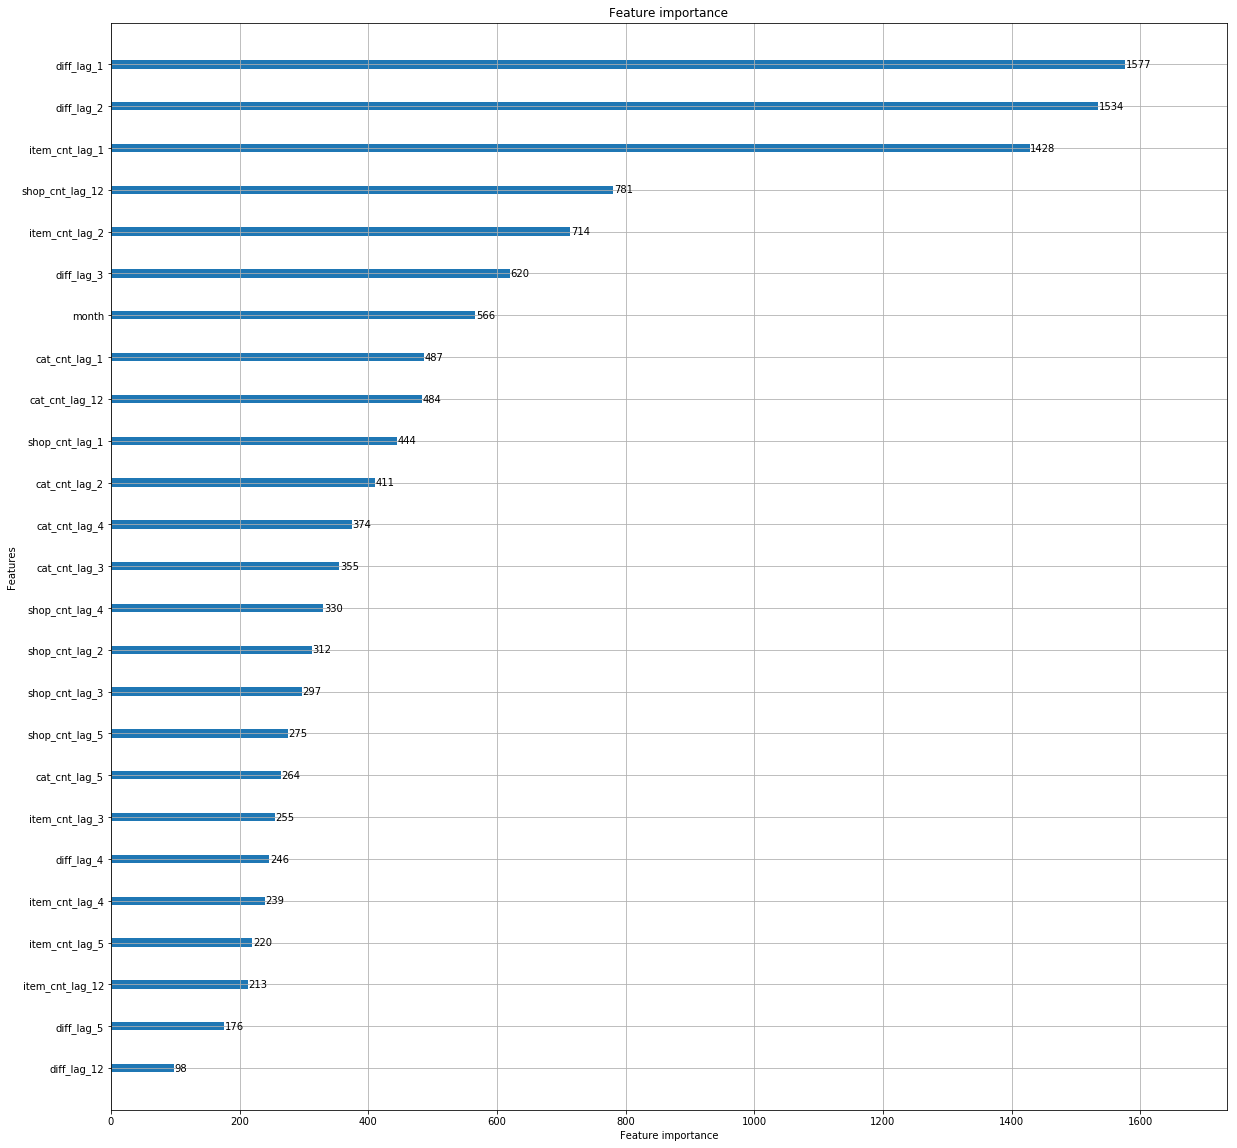

In [84]:
lgb.plot_importance(model, figsize=(20,20))

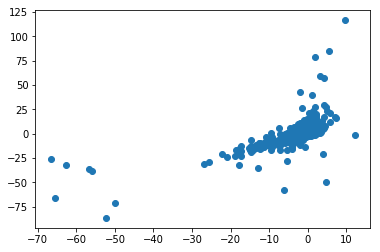

In [85]:
plt.scatter(pred_lgb[val.shop_item_cnt>0],pred_lm[val.shop_item_cnt>0])

([<matplotlib.axis.XTick at 0x221021380f0>,
 <a list of 35 Text xticklabel objects>)

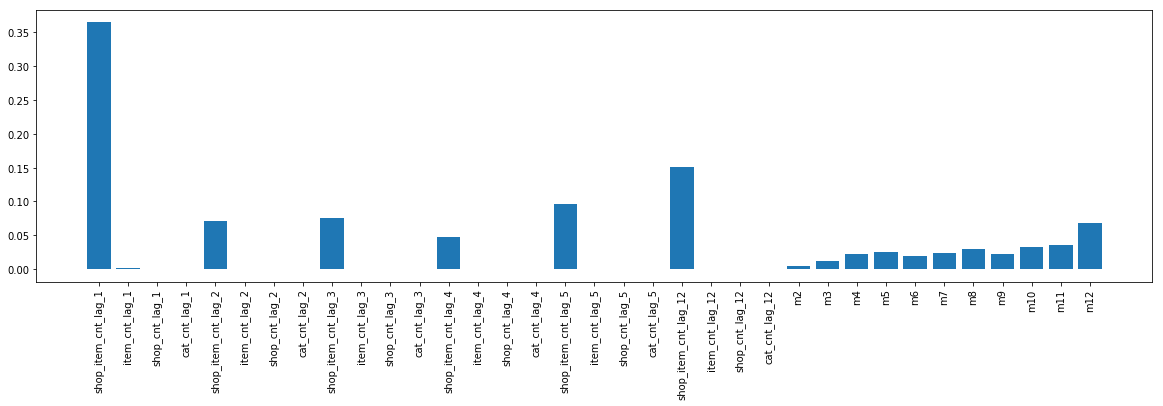

In [55]:
plt.figure(figsize=(20,5))
ticks = list(range(len(lm.coef_)))
plt.bar(ticks,height=lm.coef_)
plt.xticks(ticks,feats,rotation=90)

### Ok, why doesn't score improve???

In [57]:
val['lm_pred'] = pred_lm
val['lgb_pred'] = pred_lgb
val2 = val[val.shop_item_cnt>0]
val2.shape

(29652, 40)

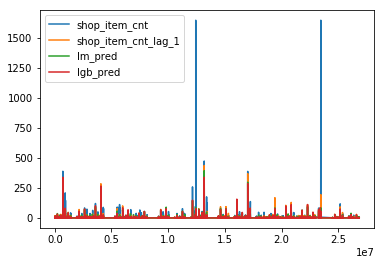

In [58]:
plt.figure(figsize=(20,5))
val2[['shop_item_cnt','shop_item_cnt_lag_1','lm_pred','lgb_pred']].plot()

## Ok there seems to be Extremely high sales of in month 32

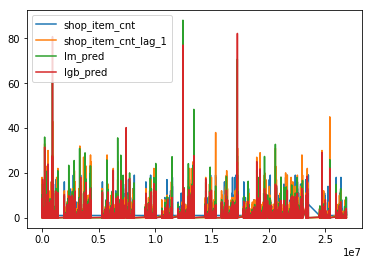

In [59]:
val2.loc[val2.shop_item_cnt<20,['shop_item_cnt','shop_item_cnt_lag_1','lm_pred','lgb_pred']].plot()

In [60]:
for col in ['shop_item_cnt_lag_1','lm_pred','lgb_pred']:
    print(col,rmse_clip(val2.loc[val2.shop_item_cnt<20,'shop_item_cnt'],val2.loc[val2.shop_item_cnt<20,col]))

shop_item_cnt_lag_1 2.2048763591676313
lm_pred 2.061136715617056
lgb_pred 2.0084886509731676


<strong>Not too bad for the normal range... 

Stacking will work;

Since there is improvement, create a submission w only time-based features </strong>

### Create a new submission

In [92]:
%%time
monthly_sales_all = pd.read_hdf(r'../data2/monthly_diff_all_shop_item_w_lag.h5','monthly_sales_all')

Wall time: 7.4 s


In [93]:
monthly_sales_all = monthly_sales_all[(monthly_sales_all.date_block_num>=12) & (monthly_sales_all.date_block_num<34)]

In [94]:
monthly_sales_all = pd.merge(monthly_sales_all,m_onehot_df,how='left',on='month')#.drop(labels=['month'],axis=1)
monthly_sales_all[:3]

,date_block_num,item_id,shop_id,diff,shop_cnt,item_cnt,cat_cnt,cat_cnt_lag_1,diff_lag_1,item_cnt_lag_1,...,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12
0,12,0,0,0.0,0.0,0.0,-129.145828,118.541672,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,13,0,0,0.0,0.0,0.0,-248.187500,-129.145828,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,14,0,0,0.0,0.0,0.0,-28.187494,-248.187500,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0


In [95]:
X_train = monthly_sales_all[feats]

In [96]:
y_train = monthly_sales_all['diff']

In [97]:
del monthly_sales_all
gc.collect()

307

In [98]:
%%time
lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':7, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':0 
              }

model = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train), 100)

Wall time: 2min 13s


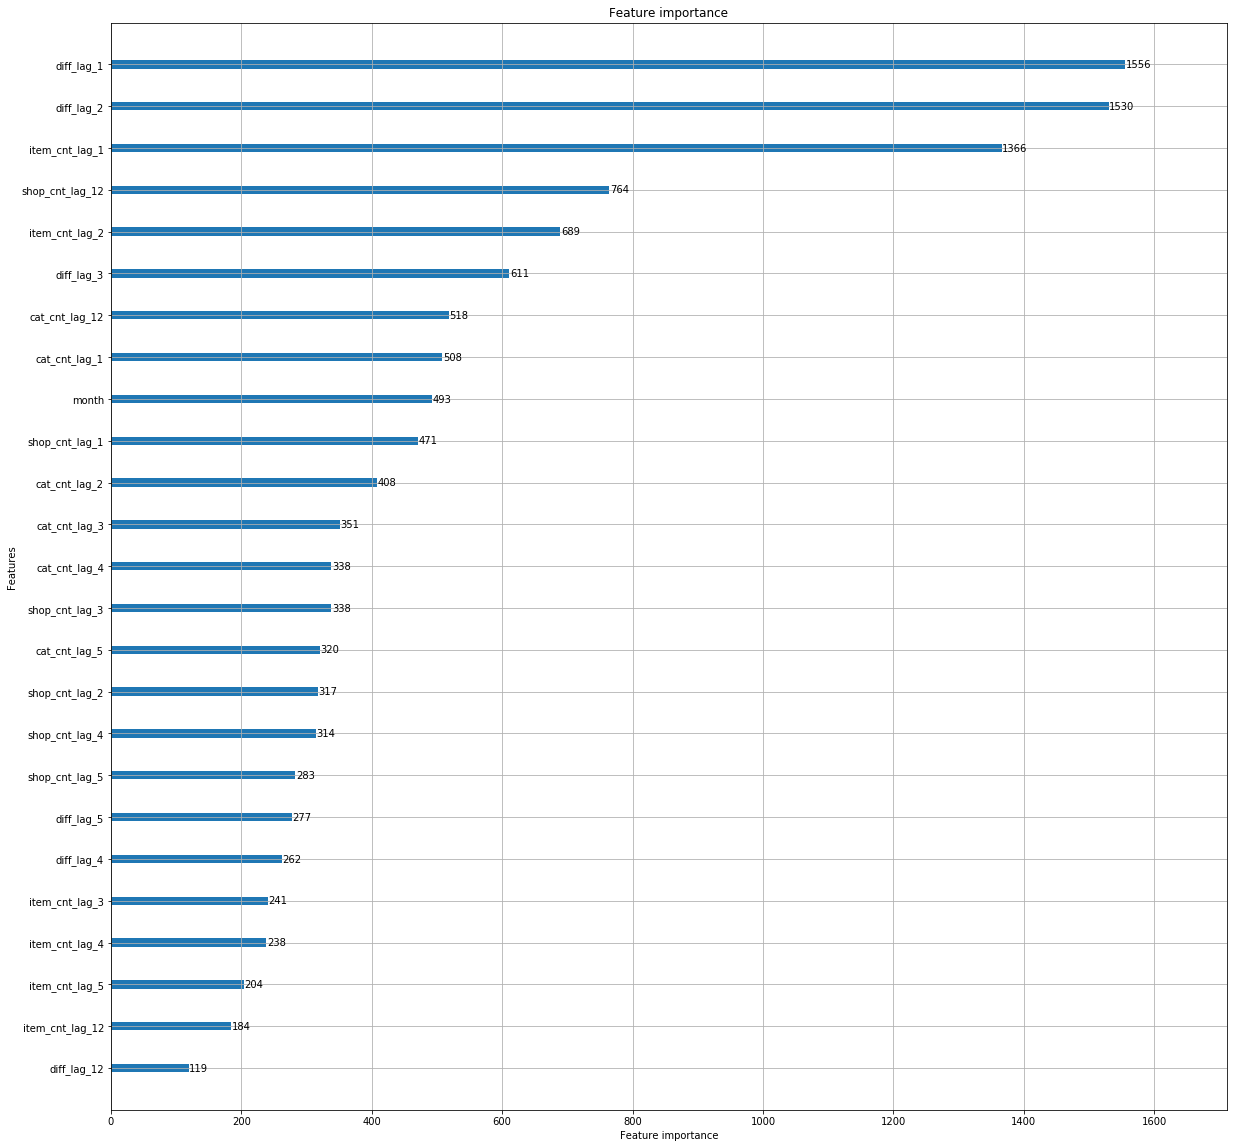

In [99]:
lgb.plot_importance(model,figsize=(20,20))

#### Read in test data and get features

In [100]:
test = pd.read_csv(r'../data/test.csv.gz')
test[:3]

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233


In [101]:
%%time
monthly_sales_all = pd.read_hdf(r'../data2/monthly_diff_all_shop_item_w_lag.h5','monthly_sales_all')

Wall time: 47.6 s


In [102]:
gc.collect()

44

In [103]:
monthly_sales_all = pd.merge(monthly_sales_all[monthly_sales_all.date_block_num==34],m_onehot_df,how='left',on='month')
monthly_sales_all[:3]

,date_block_num,item_id,shop_id,diff,shop_cnt,item_cnt,cat_cnt,cat_cnt_lag_1,diff_lag_1,item_cnt_lag_1,...,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12
0,34,0,0,0.0,0.0,0.0,-178.541656,44.812500,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
1,34,1,0,0.0,0.0,0.0,-184.000000,1.000000,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
2,34,2,0,0.0,0.0,0.0,-202.583344,0.791667,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0


In [104]:
test2 = pd.merge(test,monthly_sales_all,on=['shop_id','item_id'],how='left').fillna(0)
test2.loc[:,'m11'] = 1
print(test2.shape)
test2[:3]

(214200, 46)


,ID,shop_id,item_id,date_block_num,diff,shop_cnt,item_cnt,cat_cnt,cat_cnt_lag_1,diff_lag_1,...,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12
0,0,5,5037,34.0,0.0,-1054.0,-25.0,-242.414429,-136.683411,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0
1,1,5,5320,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0
2,2,5,5233,34.0,-1.0,-1054.0,-42.0,-586.295654,-534.433777,-2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0


In [105]:
test2['item_cnt_month'] = (model.predict(test2[feats]) + test2['shop_item_cnt_lag1']).clip(0,20)

In [106]:
test2[['ID','item_cnt_month']].to_csv(r'../output/14_1020_lgb_time_feats_on_diff_cat_top3.csv',index=False)